# Microplankton fraction

https://doi.pangaea.de/10.1594/PANGAEA.892211?format=html#download

The retrieval of percent microplankton allows for comparison with both current and historical (reported as either >20 mm or <20 mm due to filter size) phytoplankton size fraction- ated data sets. In this way, Sfm is the difference of one and Sf (Sfm = 1 − Sf) and varies from 0%, where phytoplankton is dominated by picoplankton to 100%, where it is dominated by microplankton.

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

## Load Annual Sfm data from np array 

In [3]:
loaded_Sfm_annual = np.load("/glade/scratch/gabyn/Sfm_data/Sfm_annual.npy")
loaded_Sfm_06 = np.load("/glade/scratch/gabyn/Sfm_data/Sfm_06.npy")

## Populating the X and Y arrays with actual coordinates, to see if this will help

In [4]:
# These are the latitudes 
latitude = np.zeros(4320)
for i in range(4320):
    latitude[i] = 90-0.041666666666671404*i
# These will be the longitudes
longitude = np.zeros(8640)
for j in range (8640):
    longitude[j] = 180-0.04166666666665719*j

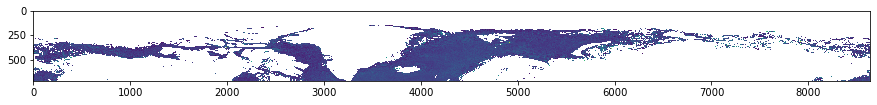

In [5]:
Sfm_annual = np.array(np.nanmean(loaded_Sfm_annual,axis=0)) # average over the months  
fig = plt.figure(figsize=(15, 10))
plt.imshow(np.swapaxes(Sfm_annual[:,0:720],1,0))

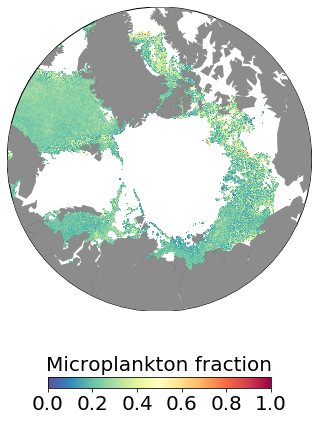

In [6]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='npstere',round=True, 
            boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)

# 2. plot the Sfm 
x,y = np.meshgrid(longitude, latitude)
xx,yy = m(x,y)
cf = m.pcolor(xx,yy,np.swapaxes(Sfm_annual,1,0),cmap='Spectral_r',vmin=0, vmax=1)

# 3. create colorbar and legend
cb = plt.colorbar(cf,ticks = [0,0.2,0.4,0.6,0.8,1],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Microplankton fraction', fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Sfm_1998-2015_annual_AO.png', dpi=600, bbox_inches='tight')

#### There are deffinitely more points when you average through the whole time series 1998-2015, so this is good, maybe this will give a better understanding on how it differs from SPECTRA, or have a better idea of the general contirbution of phytoplankton in the Arctic Ocean

## Plot the Arctic, to see how much information there is in the Arctic

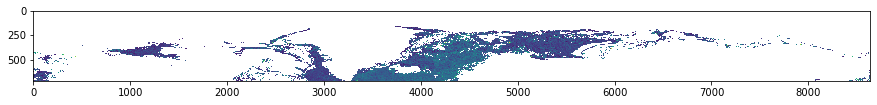

In [8]:
Sfm_06 = np.array(np.nanmean(loaded_Sfm_06,axis=0)) # average over the months  
fig = plt.figure(figsize=(15, 10))
plt.imshow(np.swapaxes(Sfm_06[:,0:720],1,0))

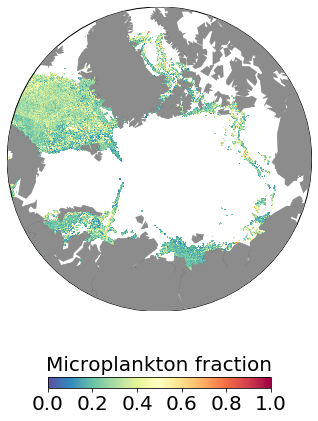

In [17]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='npstere',round=True, 
            boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)

# 2. plot the Sfm 
x,y = np.meshgrid(longitude, latitude)
xx,yy = m(x,y)
cf = m.pcolor(xx,yy,np.swapaxes(np.nanmean(ds_06,axis=0),1,0),cmap='Spectral_r',vmin=0, vmax=1)

# 3. create colorbar and legend
cb = plt.colorbar(cf,ticks = [0,0.2,0.4,0.6,0.8,1],shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Microplankton fraction', fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Sfm_1998-2015_06_AO.png', dpi=600, bbox_inches='tight')

## Now Calculate the Sfm with SPECTRA output

In [5]:
### 20 year climatology GNG595 from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim/*', recursive=True),
                      key=numericalSort)
spc = xr.open_mfdataset(newNCDFfiles,combine='by_coords')

In [6]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [11]:
## Gaby's Path 
import os
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'phytoplankton_input_data.csv')
sizes = sizes.sort_values('ESD_um') # sorting sizes by mass in ugC 
sizes

,type,ESD_um,sname,lname,index,size_range_um,Nfixer,imp_calcifier,exp_calcifier,silicifier,...,gQfe_min,kFe,loss_thres,loss_thres2,temp_thres,mort_per_day,mort2_per_day,agg_rate_min,agg_rate_max,loss_poc
1,autotroph,0.891251,pp,Picoplankton,2,"[0.466,1.703)",False,False,False,False,...,0.000003,0.000004,0.01,0.000,-10,0.019405,0.035,0.01,0.5,0
2,autotroph,3.254618,mp1,Mixed Phytoplankton 1,3,"[1.703,6.219)",False,True,False,False,...,0.000003,0.000014,0.01,0.000,-10,0.031453,0.035,0.01,0.5,0
0,autotroph,6.166670,diaz,Diazotroph,1,"[3.227,11.784)",True,False,False,False,...,0.000003,0.000038,0.02,0.001,15,0.022353,0.035,0.01,0.5,0
3,autotroph,11.885022,mp2,Mixed Phytoplankton 2,4,"[6.219,22.712)",False,True,False,False,...,0.000003,0.000046,0.01,0.000,-10,0.034458,0.035,0.01,0.5,0
6,autotroph,29.376497,diat1,Diatoms 1,7,"[20.016,43.115)",False,False,False,True,...,0.000003,0.000104,0.02,0.000,-10,0.044360,0.035,0.01,0.5,0
4,autotroph,43.401026,mp3,Mixed Phytoplankton 3,5,"[22.712,82.937)",False,False,False,False,...,0.000003,0.000147,0.01,0.000,-10,0.019696,0.035,0.01,0.5,0
7,autotroph,63.277600,diat2,Diatoms 2,8,"[43.115,92.87)",False,False,False,True,...,0.000003,0.000207,0.02,0.000,-10,0.033395,0.035,0.01,0.5,0
8,autotroph,136.301301,diat3,Diatoms 3,9,"[92.87,200.044)",False,False,False,True,...,0.000003,0.000412,0.02,0.000,-10,0.025140,0.035,0.01,0.5,0
5,autotroph,158.489319,mp4,Mixed Phytoplankton 4,6,"[82.937,302.866)",False,False,False,False,...,0.000003,0.000472,0.01,0.000,-10,0.011818,0.035,0.01,0.5,0


## Catogarazing plankton on SPECTRA

| initials  | Name                      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp`      | Microplankton             | >20 $\mu m$        |
| `np`      | Nanoplaknton              | 2 - 20 $\mu m$     |
| `pp`      | Picoplankton              | 0.2 - 2 $\mu m$    |

## However, here to compare with Mouw et al. 2010, they compare just between >20 $\mu m$ and <20 $\mu m$ 

| initials  | Name                      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp`      | Microplankton             | >20 $\mu m$        |
| `pp`      | Picoplankton              | < 20 $\mu m$       |

## Currently, this is how these different plankton types fall within these sizes
| Variable  | plankton composition      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp`      |diat1,mp3,diat2,diat3,mp4  | >20 $\mu m$        |
| `pp`      |pp, mp1, diaz,mp2          | < 20 $\mu m$       |

In this is an absorption-based approach from Mouw and Yoder (2010) (doi:10.1029/2010JC006337), the chlorophyll-specific absorption spectra for phytoplankton size class extremes, pico- (0.2-2 μm) and microplankton (> 20 μm), are weighted by Sfm. Sfm is estimated from a look-up table containing simulated [Chl], adg(443), Rrs(λ), and Sfm. For a given pixel, satellite-estimated [Chl] and adg(443), are used to narrow the search space within the look-up table. Of the remaining options, the closest simulated Rrs(λ) to the satellite-observed Rrs(λ) is selected and the associated Sfm is assigned.

### Only using picoplankton these categories would look like this instead
| Variable  | plankton composition      | Diameter           |
|-----------|---------------------------|--------------------|
| `mp`      |diat1,mp3,diat2,diat3,mp4  | >20 $\mu m$        |
| `pp`      |pp                         | 0.2-2 $\mu m$      |

In [7]:
mp = spc.diat1Chl[5,0,:,:]+spc.mp3Chl[5,0,:,:]+spc.diat2Chl[5,0,:,:]+spc.diat3Chl[5,0,:,:]+spc.mp4Chl[5,0,:,:]
pp = spc.ppChl[5,0,:,:]+spc.mp1Chl[5,0,:,:]+spc.diazChl[5,0,:,:]+spc.mp2Chl[5,0,:,:]
totalp = spc.diat1Chl[5,0,:,:]+spc.mp3Chl[5,0,:,:]+spc.diat2Chl[5,0,:,:]+spc.diat3Chl[5,0,:,:]+spc.mp4Chl[5,0,:,:]+spc.ppChl[5,0,:,:]+spc.mp1Chl[5,0,:,:]+spc.diazChl[5,0,:,:]+spc.mp2Chl[5,0,:,:]

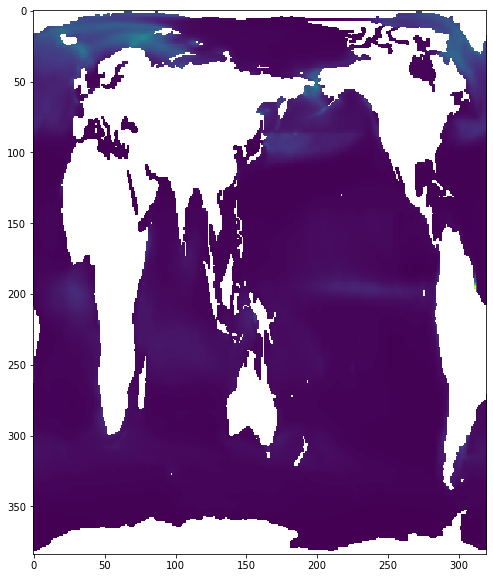

In [78]:
fig = plt.figure(figsize=(15, 10))
plt.imshow(np.flip(totalp, axis=0))

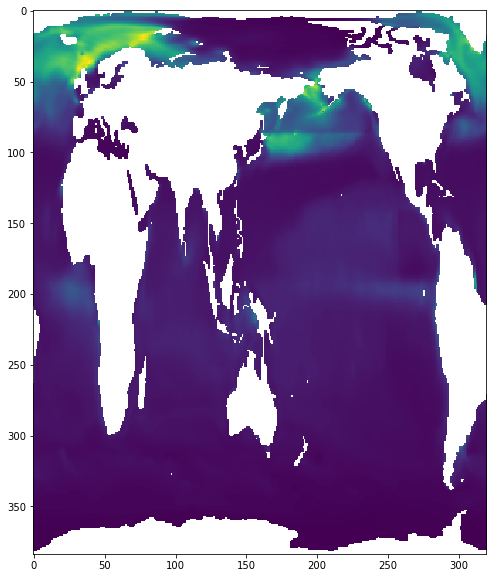

In [96]:
fig = plt.figure(figsize=(15, 10))
plt.imshow(np.flip(pp, axis=0))

In [8]:
Sf_SPECTRA = pp/totalp
Sfm_SPECTRA = mp/totalp

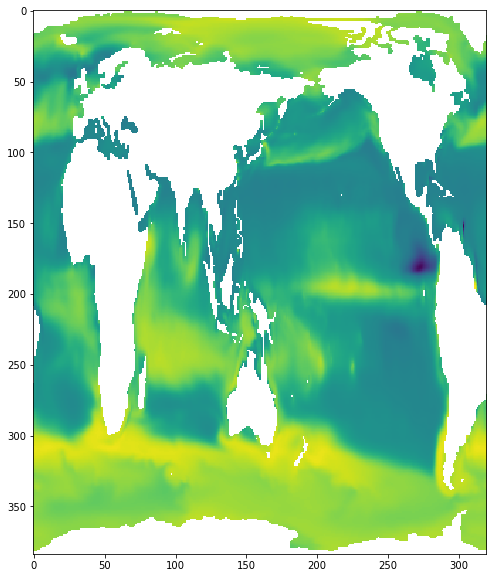

In [102]:
fig = plt.figure(figsize=(15, 10))
plt.imshow(np.flip(Sfm_SPECTRA, axis=0))

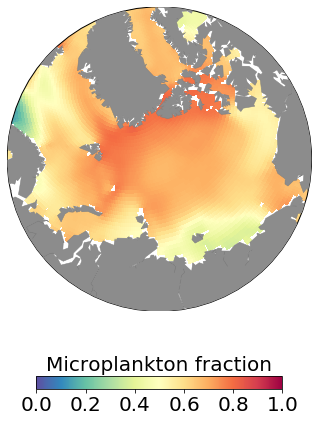

In [103]:
# 1. Draw the map background
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, 
            boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)

# 2. plot the Sfm 
tlon, tlat, chl = adjust_pop_grid(spc.TLONG, spc.TLAT, Sfm_SPECTRA)
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r',vmin=0,vmax=1)

# 3. create colorbar and legend
cb = plt.colorbar(cf,ticks = [0,0.2,0.4,0.6,0.8,1],shrink=0.75,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Microplankton fraction', fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Sfm_SPECTRA_AO_06.png',dpi=600, bbox_inches='tight')

### Overall there is a higher contribution of microplankton in SPECTRA than what it is seen in the dataset, there is not information in the central Arctic, but there seems to be more microplankton there in SPECTRA

## Now create one that is for the average throughout the whole year 

In [9]:
mp_annual = (np.nanmean(spc.diat1Chl[:,0,:,:],axis=0)+
      np.nanmean(spc.mp3Chl[:,0,:,:],axis=0)+
      np.nanmean(spc.diat2Chl[:,0,:,:],axis=0)+
      np.nanmean(spc.diat3Chl[:,0,:,:],axis=0)+
      np.nanmean(spc.mp4Chl[:,0,:,:],axis=0))
totalp_annual = (np.nanmean(spc.diat1Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.mp3Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.diat2Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.diat3Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.mp4Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.ppChl[:,0,:,:],axis=0)+
          np.nanmean(spc.mp1Chl[:,0,:,:],axis=0)+
          np.nanmean(spc.diazChl[:,0,:,:],axis=0)+
          np.nanmean(spc.mp2Chl[:,0,:,:],axis=0))

In [10]:
Sfm_SPECTRA_annual = mp_annual/totalp_annual

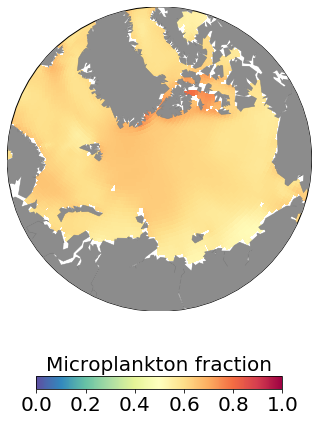

In [14]:
# 1. Draw the map background
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 3, 1)
m = Basemap(projection='npstere',round=True, 
            boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)

# 2. plot the Sfm 
tlon, tlat, chl = adjust_pop_grid(spc.TLONG, spc.TLAT, Sfm_SPECTRA_annual)
x,y = m(tlon, tlat)
cf = m.pcolor(x,y,chl,cmap='Spectral_r',vmin=0,vmax=1)

# 3. create colorbar and legend
cb = plt.colorbar(cf,ticks = [0,0.2,0.4,0.6,0.8,1],shrink=0.75,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Microplankton fraction', fontsize=20)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Sfm_SPECTRA_AO_annual.png',dpi=600, bbox_inches='tight')

In [23]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat1Chl.*.nc', recursive=True))
diat1_ds = xr.open_mfdataset(diat1_inds,combine='by_coords')

diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat2Chl.*.nc', recursive=True))
diat2_ds = xr.open_mfdataset(diat2_inds,combine='by_coords')

diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diat3Chl.*.nc', recursive=True))
diat3_ds = xr.open_mfdataset(diat3_inds,combine='by_coords')

mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp1Chl.*.nc', recursive=True))
mp1_ds = xr.open_mfdataset(mp1_inds,combine='by_coords')

mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp2Chl.*.nc', recursive=True))
mp2_ds = xr.open_mfdataset(mp2_inds,combine='by_coords')

mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp3Chl.*.nc', recursive=True))
mp3_ds = xr.open_mfdataset(mp3_inds,combine='by_coords')

mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_mp4Chl.*.nc', recursive=True))
mp4_ds = xr.open_mfdataset(mp4_inds,combine='by_coords')

pp_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ppChl.*.nc', recursive=True))
pp_ds = xr.open_mfdataset(pp_inds,combine='by_coords')

diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_diazChl.*.nc', recursive=True))
diaz_ds = xr.open_mfdataset(diaz_inds,combine='by_coords')

In [26]:
phytoChl = np.stack([pp_ds.ppChl, mp1_ds.mp1Chl, diaz_ds.diazChl, 
                               diat1_ds.diat1Chl, mp2_ds.mp2Chl, diat2_ds.diat2Chl, 
                               mp3_ds.mp3Chl, diat3_ds.diat3Chl, mp4_ds.mp4Chl])
mpChl = np.stack([diat1_ds.diat1Chl,mp3_ds.mp3Chl,diat2_ds.diat2Chl,
                 diat3_ds.diat3Chl,mp4_ds.mp4Chl])
phytoChl = np.nansum(phytoChl, axis =(0,2))
mpChl = np.nansum(mpChl, axis=(0,2))

In [28]:
Sfm_SPECTRA = mpChl/phytoChl

In [29]:
Sfm_SPECTRA.shape

(12, 180, 360)

In [31]:
loaded_Sfm_annual.shape

(12, 8640, 4320)

## Now create climatologies from the model and the observations! 

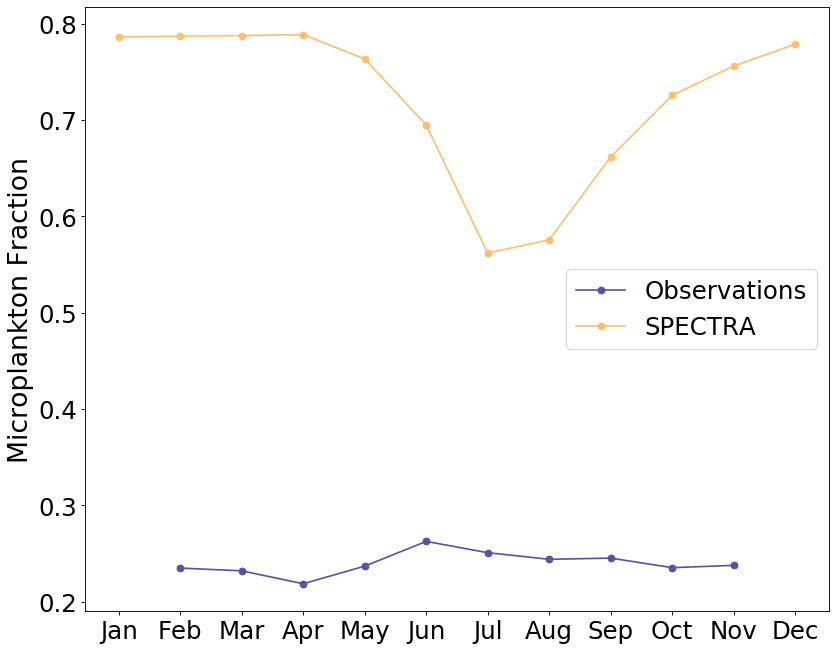

In [32]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax.plot(months,np.nanmean(loaded_Sfm_annual[:,:,0:720],axis=(1,2)), '-o', color=cmap(9),label='Observations')
ax.plot(months,np.nanmean(Sfm_SPECTRA[:,149:179, :], axis=(1,2)), '-o', color=cmap(3),label='SPECTRA')
ax.legend(loc='top right', fontsize=22); 
#ax.set_ylim(0,2.5)
#ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
#ax.legend(loc='top right', fontsize=22)
ax.set_ylabel('Microplankton Fraction', fontsize=24)
#ax2.set_ylabel('Ice Fraction', fontsize=24)
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
pylab.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Sfm_motnhly_ModelvsObs_'+year+'year.png', dpi=600, bbox_inches='tight')